Write a python program to implement the following motion estimation algorithms 1) Full search; 2) Three step search 3) Diamond search; 4) Diamond search with predicted initial positions; Test video sequences in YUV format (`akiyo_cif.yuv`) Perform motion estimation only with the Y component of the video frame. From each frame F(n) and its previous frame F(n−1), apply the above algorithms to find the best matches for all MBs, compute the average SAD, record the average number of SAD computations, and compare the performance (average SAD, average number of SAD computations) by plotting the following figures and table. 

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def read_YUV_file(file_path, frame_index, frame_height=288, frame_width=352):
    Y_size = frame_height * frame_width
    UV_size = Y_size // 2

    frame_size = Y_size + UV_size

    with open(file_path, 'rb') as f:
        f.seek(frame_size * frame_index)
        Y_data = np.frombuffer(f.read(Y_size), dtype=np.uint8).reshape(frame_height, frame_width)
        U_data = np.frombuffer(f.read(UV_size // 2), dtype=np.uint8).reshape(frame_height // 2, frame_width // 2)
        V_data = np.frombuffer(f.read(UV_size // 2), dtype=np.uint8).reshape(frame_height // 2, frame_width // 2)

    return Y_data

In [4]:
def SAD(block1, block2):
    return np.sum(np.abs(block1 - block2))

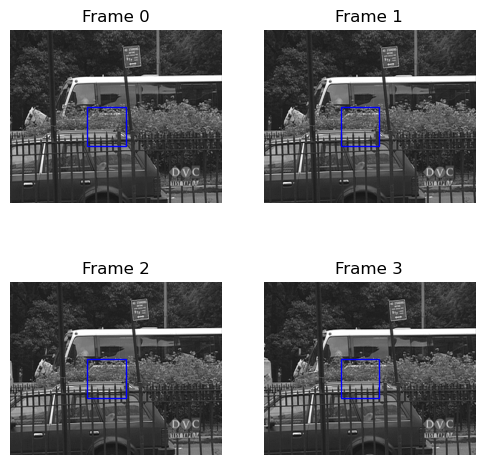

In [66]:
# plot the first 4 frames of the video
def plot_video_frames(fn, frame_height=288, frame_width=352):
    plt.figure(figsize=(6, 6))
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.imshow(read_YUV_file(fn, frame_index=i)[0],cmap='gray')
        plt.gca().add_patch(plt.Rectangle((block_start_col, block_start_row), block_size, block_size, edgecolor='b', facecolor='none'))
        plt.title(f'Frame {i}')
        plt.axis('off')
    plt.show()
plot_video_frames('bus_cif.yuv')

## Search Alogrithm

In [70]:
def full_search(block, search_area):
    min_sad = float('inf')
    dx, dy = 0, 0
    block_size = block.shape
    sad_call_count = 0
    # print block and search area shape
    # print("block shape: ", block.shape)
    # print("search area shape: ", search_area.shape)

    for i in range(search_area.shape[0] - block_size[0] + 1): # row
        for j in range(search_area.shape[1] - block_size[1] + 1): # col
            search_block = search_area[i:i+block_size[0], j:j+block_size[1]]
            sad = SAD(block, search_block)
            sad_call_count = sad_call_count + 1
            
            if sad < min_sad:
                min_sad = sad
                dy, dx = i, j
                
    # print("original dx, dy: ", dx, dy)
    return dx, dy, min_sad, sad_call_count

In [101]:
def block_search(frame1, frame2, block_size, search_area_size, block_start_row, block_start_col, search_alogorithm):

    # Select a block from the first frame
    block = frame1[block_start_row:block_start_row+block_size, block_start_col:block_start_col+block_size]

    # Select a search area from the second frame
    search_area_start_row = np.maximum(block_start_row - (search_area_size - block_size) // 2, 0)
    search_area_start_col = np.maximum(block_start_col - (search_area_size - block_size) // 2, 0)
    search_area_end_row = np.min([search_area_start_row + search_area_size, frame1.shape[0]])
    search_area_end_col = np.min([search_area_start_col + search_area_size, frame1.shape[1]])
    
    # print the search area location
    # print(f"Search area: ({search_area_start_row}, {search_area_start_col}) - ({search_area_end_row}, {search_area_end_col})")
    search_area = frame2[search_area_start_row:search_area_end_row, search_area_start_col:search_area_end_col]

    # Apply full search algorithm
    dx, dy, min_sad, sad_call_count = search_alogorithm(block, search_area)

    dy = dy + search_area_start_row - block_start_row
    dx = dx + search_area_start_col - block_start_col

    # Print the result
    # print(f"Displacement: ({dx}, {dy}), Minimum SAD: {min_sad}")
    
    return dx, dy, min_sad, sad_call_count

In [130]:
# iterate Y1 in 16x16 blocks
def split_and_search(frame1, frame2,block_size, search_area_size, search_alogorithm):
    block_size = 16
    search_area_size = 30
    sad_call_count = 0
    dx_list = []
    dy_list = []
    min_sad_list = []
    frame1_mv = frame1.copy()
    #frame1_mv = np.zeros(frame1.shape)
    for block_start_row in range(0, frame1.shape[0], block_size):
        for block_start_col in range(0, frame1.shape[1], block_size):
            dx, dy, min_sad, sad_call_count = block_search(frame1, frame2, block_size, search_area_size, block_start_row, block_start_col, search_alogorithm)
            dx_list.append(dx)
            dy_list.append(dy)
            min_sad_list.append(min_sad)
            # print the position of current block
            # print(f"Block: ({block_start_row}, {block_start_col}) - ({block_start_row+block_size}, {block_start_col+block_size})")
            # print(f"dx: {dx}, dy: {dy}, apply area: ({block_start_row+dy}, {block_start_col+dx}) - ({block_start_row+block_size+dy}, {block_start_col+block_size+dx})")
            # print(frame1_mv[block_start_row+dy:block_start_row+block_size+dy, block_start_col+dx:block_start_col+block_size+dx].shape)
            # print(frame1[block_start_row:block_start_row+block_size, block_start_col:block_start_col+block_size].shape)
            frame1_mv[block_start_row+dy:block_start_row+block_size+dy, block_start_col+dx:block_start_col+block_size+dx] = frame1[block_start_row:block_start_row+block_size, block_start_col:block_start_col+block_size]
    # calculate the avg SAD
    avg_sad = np.mean(min_sad_list)
    # calculate average number of SAD computations
    avg_sad_call_count = sad_call_count / len(min_sad_list)
    return frame1_mv, avg_sad, avg_sad_call_count



akiyo_cif.yuv has 300 frames.

In [131]:
Y1= read_YUV_file('bus_cif.yuv', frame_index=0)
Y2= read_YUV_file('bus_cif.yuv', frame_index=1)
frame_mv, svg_sad, avg_sad_call_count = split_and_search(Y1,Y2,16,30, full_search)

In [132]:
def mse(frame1, frame2):
    return np.mean((frame1 - frame2) ** 2)

In [133]:
# mse of Y2 - Y1
print(mse(Y2, Y1))
# mse of Y2 - frame_mv
print(mse(Y2, frame_mv))

74.67678740530303
78.48087318497475


In [122]:
# plot frame_mv, Y1, Y2 and residual
def plot_frame_mv(frame_mv, Y1, Y2):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes[0, 0].imshow(Y1, cmap='gray')
    axes[0, 0].set_title('Frame 1')
    axes[0, 1].imshow(Y2-Y1, cmap='gray')
    axes[0, 1].set_title('Frame 2 - Frame 1')
    axes[1, 0].imshow(frame_mv, cmap='gray')
    axes[1, 0].set_title('Frame 1 with motion vectors')
    axes[1, 1].imshow(Y2 - frame_mv, cmap='gray')
    axes[1, 1].set_title('Frame2 - Frame 1 with motion vectors')
    plt.show()

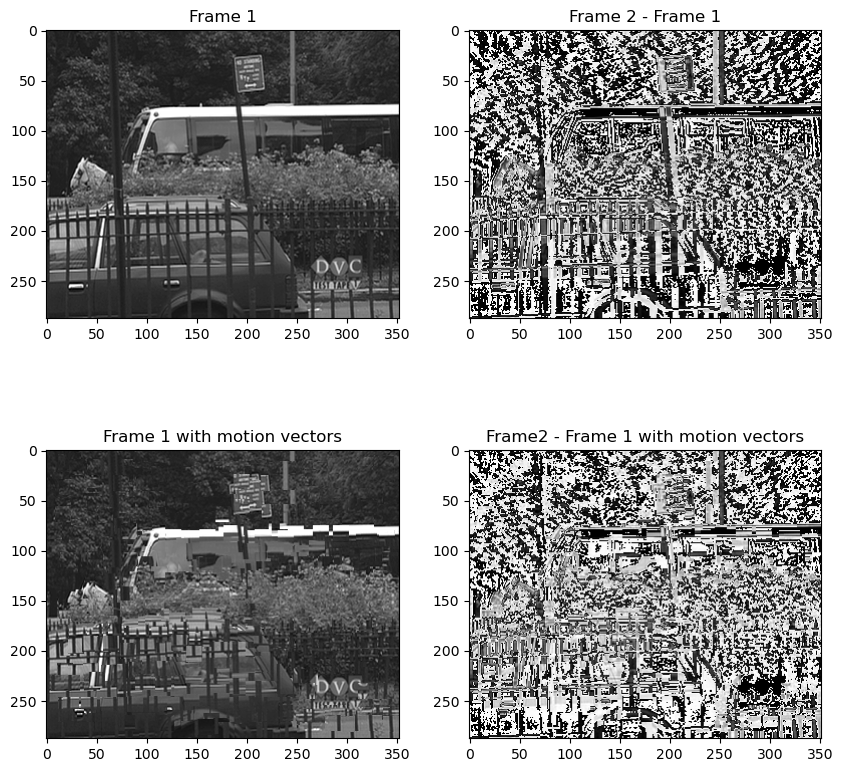

In [123]:
plot_frame_mv(frame_mv, Y1, Y2)

In [135]:
# calculate the mse per pixel for first 100 frames
mse_list = []
def mse_per_pixel(frame1, frame2):
    frame_mv, svg_sad, avg_sad_call_count = split_and_search(frame1,frame2,16,30,full_search)
    mse_list.append(mse(frame2, frame_mv))

In [136]:
for i in range(100):
    print(f"Frame {i} and {i+1}")
    Y1= read_YUV_file('akiyo_cif.yuv', frame_index=i)
    Y2= read_YUV_file('akiyo_cif.yuv', frame_index=i+1)
    mse_per_pixel(Y1, Y2)

Frame 0 and 1
Frame 1 and 2
Frame 2 and 3
Frame 3 and 4
Frame 4 and 5
Frame 5 and 6
Frame 6 and 7
Frame 7 and 8
Frame 8 and 9
Frame 9 and 10
Frame 10 and 11
Frame 11 and 12
Frame 12 and 13
Frame 13 and 14
Frame 14 and 15
Frame 15 and 16
Frame 16 and 17
Frame 17 and 18
Frame 18 and 19
Frame 19 and 20
Frame 20 and 21
Frame 21 and 22
Frame 22 and 23
Frame 23 and 24
Frame 24 and 25
Frame 25 and 26
Frame 26 and 27
Frame 27 and 28
Frame 28 and 29
Frame 29 and 30
Frame 30 and 31
Frame 31 and 32
Frame 32 and 33
Frame 33 and 34
Frame 34 and 35
Frame 35 and 36
Frame 36 and 37
Frame 37 and 38
Frame 38 and 39
Frame 39 and 40
Frame 40 and 41
Frame 41 and 42
Frame 42 and 43
Frame 43 and 44
Frame 44 and 45
Frame 45 and 46
Frame 46 and 47
Frame 47 and 48
Frame 48 and 49
Frame 49 and 50
Frame 50 and 51
Frame 51 and 52
Frame 52 and 53
Frame 53 and 54
Frame 54 and 55
Frame 55 and 56
Frame 56 and 57
Frame 57 and 58
Frame 58 and 59
Frame 59 and 60
Frame 60 and 61
Frame 61 and 62
Frame 62 and 63
Frame 63 an

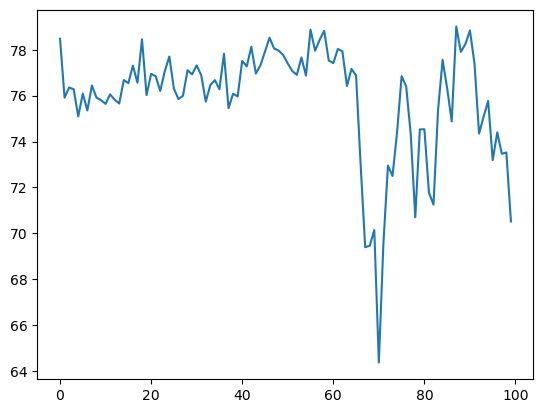

In [137]:
# plot the mse per pixel
plt.plot(mse_list)

### 3 step search

In [ ]:
def three_step_search(block, search_area, step_size=4):
    # The initial position will be the center of the search area
    center_x = search_area.shape[0] // 2
    center_y = search_area.shape[1] // 2
    block_size = block.shape

    while step_size >= 1:
        min_sad = float('inf')
        dx, dy = center_x, center_y

        # Explore the 8 points around the center point at the given step size
        for i in range(center_x - step_size, center_x + step_size + 1, step_size):
            for j in range(center_y - step_size, center_y + step_size + 1, step_size):
                # Check boundaries
                if i < 0 or j < 0 or (i + block_size[0]) > search_area.shape[0] or (j + block_size[1]) > search_area.shape[1]:
                    continue

                search_block = search_area[i:i + block_size[0], j:j + block_size[1]]
                sad = SAD(block, search_block)

                if sad < min_sad:
                    min_sad = sad
                    dx, dy = i, j

        # Update the new center point
        center_x, center_y = dx, dy

        # Reduce the step size
        step_size //= 2

    return dx, dy, min_sad
